In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import optimizer
import sinkhorn_ops
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment
from tensorflow import keras
%matplotlib inline
import tensorflow_datasets as tfds
from time import time
   
from PIL import Image
import numpy as np


In [2]:
from scipy.special import logsumexp
def sinkhorn(log_alpha, n_iters=20):

    for n in range(n_iters):
        log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
        log_alpha -= logsumexp(log_alpha, axis=0, keepdims=True)
        if n%2000==0:
            print(n)
    log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
    return np.exp(log_alpha)

def batch_split(batch, n_squares_side, n_channels=1):
    if(n_channels ==1):
        side = int(np.sqrt(batch.shape[1]))
    else:
        side = batch.shape[1]
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    print(np.sqrt(batch.shape[2]/n_channels))
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    if(n_squares_side==6):
        side = 30
        side_square = 5
    if(n_squares_side==7):
        side = 28
        side_square = 4
    if(n_squares_side==8):
        side = 32
        side_square = 4
    if(n_squares_side==9):
        side = 27
        side_square = 3
    if(n_squares_side==16):
        side = 160
        side_square = 10
    if(n_squares_side==14):
        side = 196
        side_square = 14
    if(n_squares_side==18):
        side = 8*18
        side_square = 8
    if(n_squares_side==20):
        side = 7*20
        side_square = 7
    if(n_squares_side==25):
        side = 25*6
        side_square = 6
    if(n_squares_side==30):
        side = 30*5
        side_square = 5
    if (n_squares_side == 37):
        side = 37 * 4
        side_square = 4
    if (n_squares_side == 45):
        side = 45 * 3
        side_square = 3
    return side, side_square

def resize_batch_color(batch, side_new, n_channels):
    batch_new = np.zeros((batch.shape[0], side_new, side_new, n_channels))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        for c in range(n_channels):
            a = imresize(batch[i,:,:,c], [side_new, side_new])
            
            a = a/255.0
            batch_new[i,:,:,c] =a
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data


In [3]:
#Define model params
batch_size = 1
batch_size_display = batch_size
n_iter_sinkhorn = 30000

temp = 500.0

#mnist data
n_squares_side = 45
n_channels = 3

n_squares = n_squares_side **2
n_gromov = 1
side, side_square = resized_dims(n_squares_side)
n_dim = int(side_square*side_square*n_channels)

In [4]:
#Now we define the main TF variables

def solve(scrambled_split,stack_scrambled_images_split,stack_real_images_split):
    
    print(scrambled_split.shape)
    log_alpha = np.reshape(stack_scrambled_images_split, [batch_size, n_squares, n_dim])
    log_alpha2 = np.reshape(stack_real_images_split, [batch_size, n_squares, n_dim])



    sq = np.sum(log_alpha **2, axis=2, keepdims=True)
    A = np.tile(sq, [1, 1, n_squares])
    B = np.tile(np.transpose(sq, [0,2 ,1]), [1, n_squares, 1])
    C = -2*np.matmul(log_alpha, np.transpose(log_alpha, [0, 2, 1]))
    s1 = A+B +C
    sq2 = np.sum(log_alpha2 **2, axis=2, keepdims=True)
    A2 = np.tile(sq2, [1, 1, n_squares])
    B2 = np.tile(np.transpose(sq2, [0,2 ,1]), [1, n_squares, 1])
    C2 = np.matmul(-2*log_alpha2, np.transpose(log_alpha2, [0, 2, 1]))
    s2 = A2+B2 +C2
    f1 = np.tile(np.sum(s1**2, axis=2, keepdims=True),[1, 1, n_squares]) 
    f2 = np.transpose(np.tile(np.sum(s2**2, axis=2, keepdims=True),[1, 1, n_squares]), [0, 2 ,1]) 
    P = np.tile(np.eye(n_squares)[np.newaxis,:,:], [batch_size, 1, 1])
    
    invP_all = []
    ma_all = []
    for l in range(n_gromov):
         
        ma = -1*(f1+f2 - 2*np.matmul(s1, np.matmul(P, s2)))
        ma_all.append(ma)
        invP_all.append(np.transpose(P, [0, 2,1]))
        for k in range(batch_size):
            print([l,k])
            P[k,:,:] = sinkhorn(ma[k,:,:]/temp, n_iters = n_iter_sinkhorn)
       
        
    
    inv_P = np.transpose(P, [0, 2,1])
   
    scrambled_split_tiled = np.reshape(scrambled_split, [batch_size, n_squares, side_square ** 2* n_channels])

    ordered_inf = np.matmul(inv_P, scrambled_split_tiled)

    return ordered_inf,inv_P, invP_all,ma_all

/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


(1, 2025, 3, 3, 3)
[0, 0]
0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
3.0
6558.59475589
(1, 2025, 3, 3, 3)
[0, 0]
0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
3.0
4383.8055582


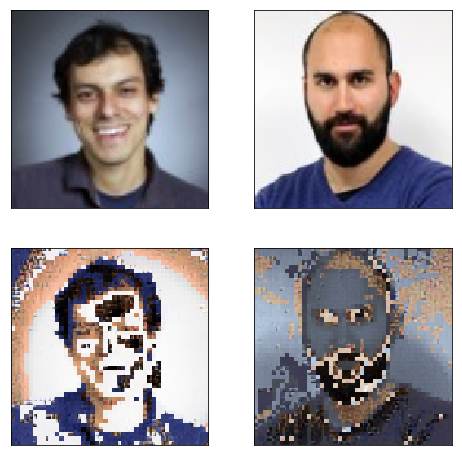

In [5]:
str1='tobar4'
str2='fontbona3'
im1 = load_image(str1+'.jpg')[np.newaxis,:,:,:]
im2 = load_image(str2+'.jpg')[np.newaxis,:,:,:]
fig, ax = plt.subplots(2,2,figsize=(8,8))
inv_perms =[]
sip=[]
for l in range(2):
    if l==0:
        np_x = im1
        np_x2 = im2
    else:
        np_x = im2
        np_x2 = im1
    np_x = resize_batch_color(np_x, side, n_channels)

    np_x2 = resize_batch_color(np_x2, side, n_channels)

    real_images_split = batch_split(np_x, n_squares_side, n_channels)
    real_images_split2 = batch_split(np_x2, n_squares_side, n_channels)

    scrambled_images_split = np.zeros(real_images_split.shape)


    i=0

    perm = np.arange(n_squares)
       
    scrambled_images_split[i,:, :, :] = real_images_split[i, perm, :, :]
    stacked_scrambled_images_split = stack_batch_split(scrambled_images_split)
    stacked_real_images_split = stack_batch_split(real_images_split2)


    unscrambled_images, inv_soft_perms_np,invP_all,ma_all=solve(scrambled_images_split,
                                                                stacked_scrambled_images_split,
                                                                stacked_real_images_split)

    unscrambled_images = unscrambled_images[:batch_size_display,:,:]
    unflatten_inf = unflatten_batch(unscrambled_images, n_channels)


    joined_inf = join_batch_split(unflatten_inf)
    joined_scrambled = join_batch_split(scrambled_images_split)
    joined_real = join_batch_split(real_images_split2)

    #Compare reconstructions with real data

    
    ax[0,l].imshow(joined_real[i,:,:,:],cmap='Greys')
    ax[0,l].get_xaxis().set_visible(False)
    ax[0,l].get_yaxis().set_visible(False)


    inv_hard_perms= np.zeros((batch_size_display, n_squares, n_squares))
    
    sip.append(scrambled_images_split)
    a=time()
    inv_hard_perms[i,:,:] = soft_to_hard(invP_all[0][i,:,:])
    inv_perms.append(inv_hard_perms)
    print(time()-a)

    hard_inf = np.matmul(inv_hard_perms, np.reshape(scrambled_images_split[:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
    unflatten_hard_inf =np.reshape(hard_inf, unflatten_inf.shape)
    joined_hard_inf =join_batch_split(unflatten_hard_inf)

    ax[1,l].imshow(joined_hard_inf[i,:,:,:],cmap='Greys')
    ax[1,l].get_xaxis().set_visible(False)
    ax[1,l].get_yaxis().set_visible(False)
    plt.savefig(str1+str2+'.png')


In [13]:
inv_hard = np.eye(n_squares)
sample = np.random.permutation(n_squares)
ims=[]
for k in range(n_squares):
    inv_hard[sample[k], sample[k]] = 0
    l = np.where(inv_perms[0][0, sample[k], :]==1)[0][0]
    inv_hard[sample[k], l] = 1

    im = np.matmul(inv_hard[np.newaxis,:,:], np.reshape(sip[0][:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
    unflatten_hard_inf =np.reshape(im, unflatten_inf.shape)
    joined_hard_inf =join_batch_split(unflatten_hard_inf)
    ims.append(joined_hard_inf)

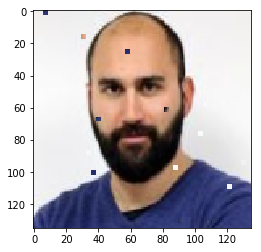

In [14]:
plt.imshow(ims[14][0,:,:])

In [15]:
print(ims[0].shape)

(1, 135, 135, 3)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020


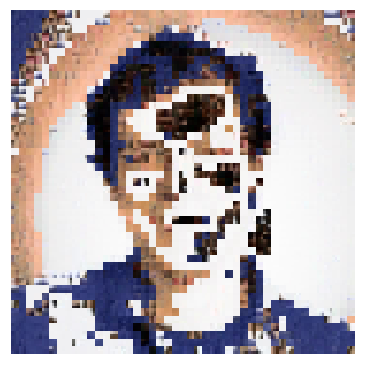

In [17]:
from __future__ import division
 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
m=640
n=480
class AnimatedGif:
    def __init__(self, size=(640, 480)):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / 100, size[1] / 100)
        ax = self.fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xticks([])
        ax.set_yticks([])
        self.images = []
 
    def add(self, image, label=''):
        plt_im = plt.imshow(image, cmap='Greys', vmin=0, vmax=1, animated=True)
        plt_txt = plt.text(10, 310, label, color='red')
        self.images.append([plt_im, plt_txt])
 
    def save(self, filename):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer='imagemagick', fps=40)
 

 
animated_gif = AnimatedGif(size=(m, n))
images = []
for i in range(0, n_squares,10):
    print(i)
    animated_gif.add(ims[i][0,:,:,:])

for k in range(20):
    animated_gif.add(ims[-1][0,:,:,:]) 
    #if i <= 15 or not (i % 10):
     
animated_gif.save(str2+str1+'.gif')


In [10]:
animated_gif.save('hola')
